# Plot ARI timeseries

### Setup

In [1]:
import sys
sys.path.append('../')
from src.hp_tuning_functions import *
from src.realtime_utils import *

In [2]:
from plotnine import *

In [3]:
def custom_theme():
    return theme(
        plot_title=element_text(size=11),
        strip_text=element_text(size=10),
        legend_title=element_text(size=9),           
        legend_text=element_text(size=8),
        axis_title=element_text(size=10),
        axis_text_x=element_text(size=8, rotation=90, ha='center', ma='right'),
        axis_text_y=element_text(size=8)
    )

# Load data

In [4]:
targets, covariates = load_realtime_training_data()

In [5]:
# test_end = get_season_end(2023)
# validation_end = get_season_end(2022)
train_end = get_season_end(2021)
validation_end = pd.Timestamp('2023-11-16')
test_end = pd.Timestamp('2024-10-06')

In [6]:
covariates = covariates[targets.start_time():test_end]

In [24]:
df = covariates.pd_dataframe().reset_index()

In [25]:
highlight_areas = pd.DataFrame({
    "xmin": [targets.start_time(), train_end, validation_end],
    "xmax": [train_end, validation_end, test_end],
    "period": ["Train", "Validation", "Test"]  
})

In [26]:
covid_start = pd.Timestamp('2019-06-30')
covid_end = pd.Timestamp('2023-07-03')

In [27]:
target_col = 'agi-are-DE'

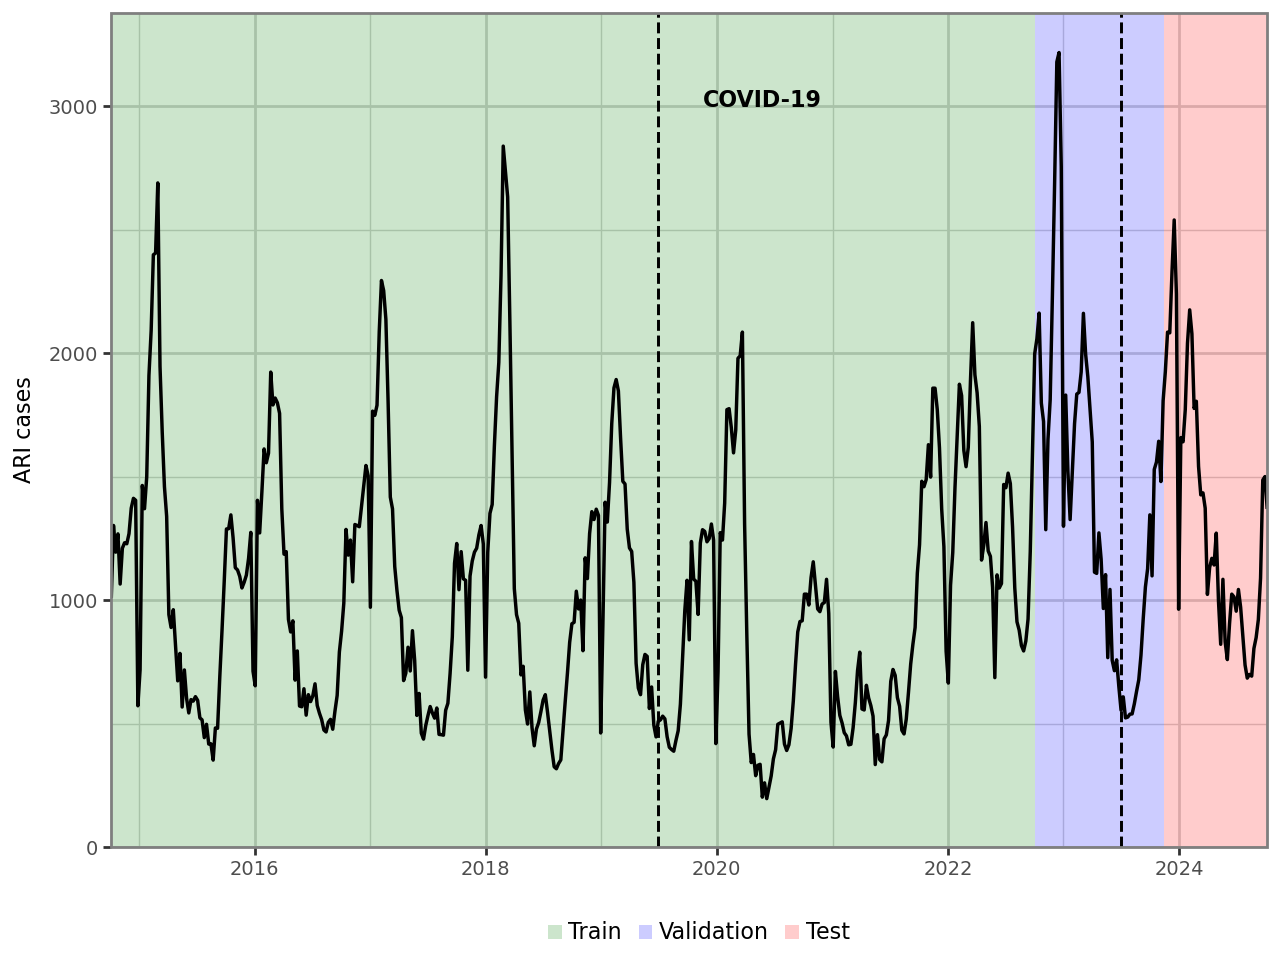

In [28]:
plot = (
    ggplot() +
    
    # Use geom_rect with the highlight_areas DataFrame and map fill to the label
    geom_rect(
        data=highlight_areas,
        mapping=aes(xmin="xmin", xmax="xmax", ymin=-float("inf"), ymax=float("inf"), fill="period"),
        alpha=0.2
    ) +
    
    # Vertical dashed line at the start of COVID-19
    geom_vline(
        xintercept=covid_start,
        linetype="dashed",
        color="black",
        size=0.6
    ) +
    geom_vline(
        xintercept=covid_end,
        linetype="dashed",
        color="black",
        size=0.6
    ) +
    
    # Label for COVID-19 start
    annotate(
        "text",
        x=covid_start + pd.Timedelta(weeks=20),
        y=df[target_col].max() * 0.925,  # Slightly below the max y value for positioning
        label="COVID-19",
        ha="left",  # Align text to the left of the line
        va="bottom",  # Position text just above the line
        size=8,
        color="black",
        fontweight="bold"
    ) +
    
    # Add the time series line
    geom_line(df, aes(x='date', y=target_col), size=0.7) +
    
    # Customize labels and scales
    labs(
        x="",
        y="ARI cases",
        fill=""  # Legend title for the areas
    ) +
    # scale_x_date(date_breaks='5 year', #minor_breaks='1 year', 
    #              date_minor_breaks = '1 year'
    #              #expand=(0, 0)
    #              #labels="%Y"
    #             ) +
    scale_x_date(breaks=[pd.Timestamp('2016-01-01'), pd.Timestamp('2018-01-01'), pd.Timestamp('2020-01-01'), pd.Timestamp('2022-01-01'), pd.Timestamp('2024-01-01')],
                 labels=['2016', '2018', '2020', '2022', '2024'],
                 minor_breaks = pd.date_range(start='2015-01-01', end='2024-01-01', freq='YS')) +
    scale_y_continuous(limits=(0, df[target_col].max()*1.05)) +
    
    # Define colors for each period in the legend
    scale_fill_manual(values={
        "Train": "green",
        "Validation": "blue",
        "Test": "red"
    }, limits=["Train", "Validation", "Test"]) + # To order the legend
    
    # Customize theme
    theme_bw() +
    custom_theme() + 
    theme(legend_position="bottom",
          axis_text_x=element_text(size=7, rotation=0),
          axis_text_y=element_text(size=7),
          legend_text=element_text(size=8),
          axis_title=element_text(size=8),
          legend_key=element_blank(),
          legend_key_size=5,
          panel_grid_minor_x=element_line(size=0.5, color="lightgrey"),
          panel_grid_major_x=element_line(size=1, color="lightgrey"),
          panel_grid_minor_y=element_line(size=0.5, color="lightgrey"),
          panel_grid_major_y=element_line(size=1, color="lightgrey")) + 
    coord_cartesian(expand=False)
)

plot

In [29]:
plot.save("../figures/ari_periods.pdf", width = 80, height = 45, units="mm", dpi=600)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 80.0 x 45.00000000000001 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/ari_periods.pdf


# Plot age groups

In [14]:
def custom_theme():
    return theme(
        plot_title=element_text(size=11),
        strip_text=element_text(size=10),
        legend_title=element_text(size=9),           
        legend_text=element_text(size=8),
        axis_title=element_text(size=10),
        axis_text_x=element_text(size=8),
        axis_text_y=element_text(size=8)
    )

In [15]:
df_long = pd.melt(df, id_vars=['date'], var_name='age_group', value_name='value')

In [16]:
df_long['age_group'] = df_long['age_group'].str.split('-', n=2).str[2]

In [17]:
df_long.age_group = df_long.age_group.replace({'DE': '00+'})

In [18]:
df_long['age_group'] = pd.Categorical(df_long['age_group'], categories=['00-04', '05-14', '15-34', '35-59', '60+', '00+'], ordered=True) 

In [19]:
df_long = df_long[df_long.age_group != '00+']

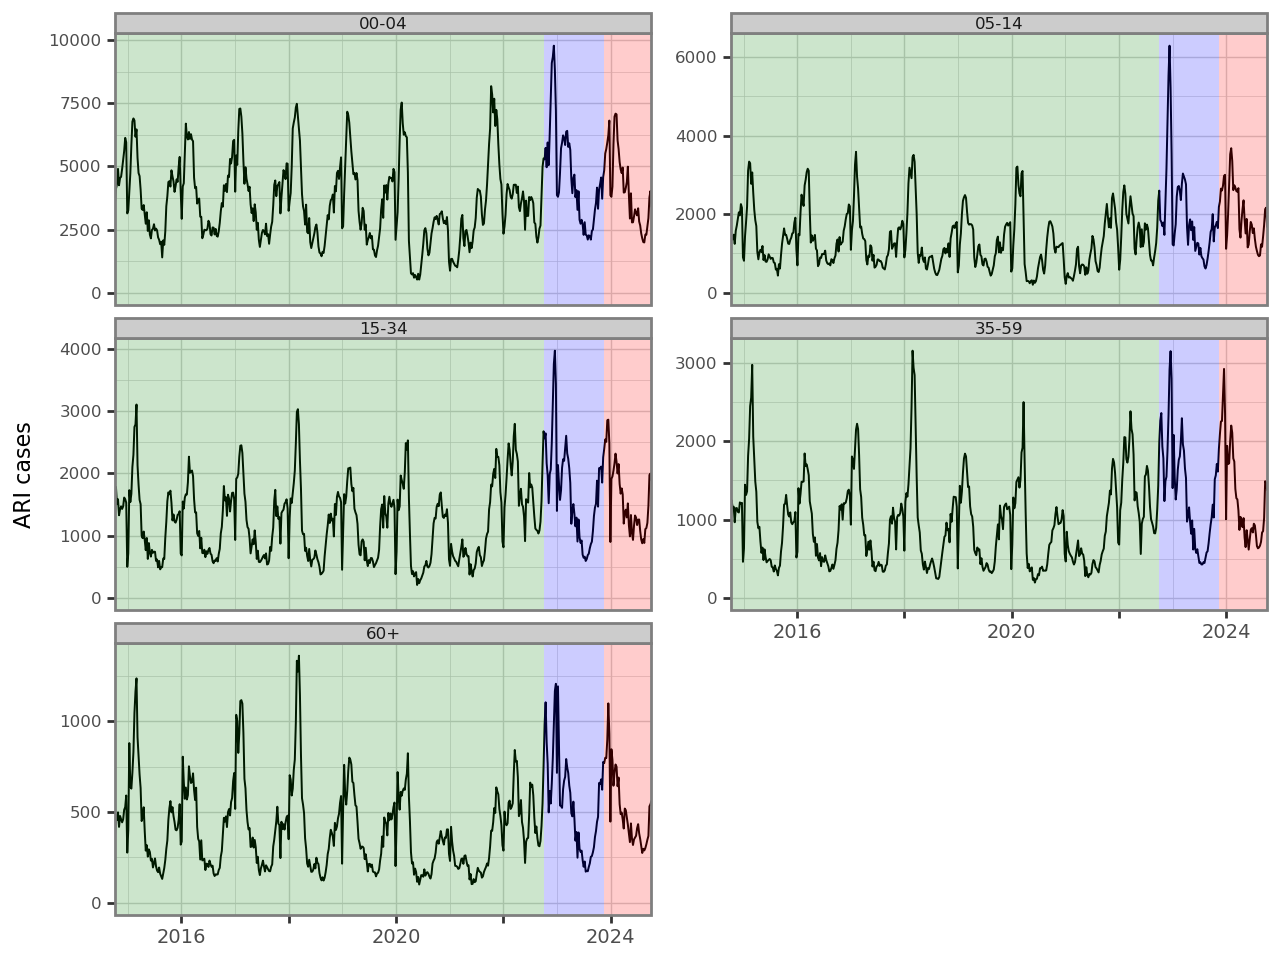

In [22]:
plot = (
    ggplot() +
    geom_line(df_long, aes(x='date', y='value'), size=0.4) +
    geom_rect(
        data=highlight_areas,
        mapping=aes(xmin="xmin", xmax="xmax", ymin=-float("inf"), ymax=float("inf"), fill="period"),
        alpha=0.2
    ) +
    facet_wrap('age_group', scales='free_y', ncol=2) +
    # Customize labels and scales
    labs(
        x="",
        y="ARI cases",
        fill=''
    ) +
    # scale_x_date(
    #     date_breaks='2 years',
    #     minor_breaks='1 year',
    #     date_labels='%Y'
    # ) +
    scale_x_date(breaks=[pd.Timestamp('2016-01-01'), pd.Timestamp('2018-01-01'), pd.Timestamp('2020-01-01'), pd.Timestamp('2022-01-01'), pd.Timestamp('2024-01-01')],
             labels=['2016', '', '2020', '', '2024'],
             minor_breaks = pd.date_range(start='2015-01-01', end='2024-01-01', freq='YS'),
             expand=(0,0,0,0)) +
    scale_y_continuous(limits=(0, None)) +
    
    # Define colors for each period in the legend
    scale_fill_manual(values={
        "Train": "green",
        "Validation": "blue",
        "Test": "red"
    }, limits=["Train", "Validation", "Test"]) + # To order the legend
    
    # Customize theme
    theme_bw() +
    custom_theme() +
    theme(#legend_position=(0.9, 0.05),
          #legend_direction='horizontal',
          #legend_key=element_blank(),
          legend_position = 'none',
          #panel_grid_minor = element_line(color='#D3D3D3', size=0.5))# +
          strip_text=element_text(size=6, margin={'t': 1, 'b': 1}),
          #strip_background=element_rect(size=0.5, color='grey', fill='lightgrey'),
          axis_text_x=element_text(size=7, rotation=0),
          axis_text_y=element_text(size=6),
          legend_text=element_text(size=8),
          axis_title=element_text(size=8),
          legend_key=element_blank(),
          legend_key_size=5,
          panel_grid_minor_x=element_line(size=0.25, color="lightgrey"),
          panel_grid_major_x=element_line(size=0.5, color="lightgrey"),
          panel_grid_minor_y=element_line(size=0.25, color="lightgrey"),
          panel_grid_major_y=element_line(size=0.5, color="lightgrey")) 
    #coord_cartesian(expand=True)
)

plot

In [23]:
plot.save("../figures/ari_age.pdf", width = 80, height = 45, units="mm", dpi=600)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 80.0 x 45.00000000000001 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/ari_age.pdf
